In [1]:
import os, sys, glob, json
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 1

# Sanity check on web-scraped TSV files

In [6]:
tsv_files = glob.glob("../data/tsv/*/*.tsv")
num_lines = lambda x: sum(1 for line in open(x))

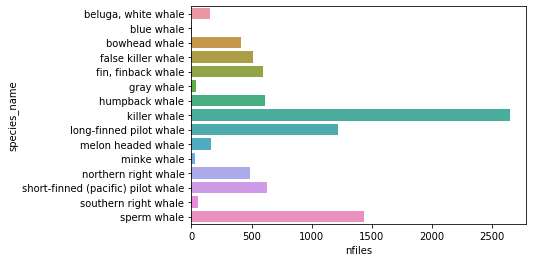

In [26]:
# Quick check on number of files
file_stats = {"species_name":[],"year":[],"nfiles":[]}
for file in tsv_files:
    file_stats["species_name"].append(os.path.basename(os.path.dirname(file)))
    file_stats["year"].append(file.rsplit('_',1)[1].split('.')[0])
    file_stats["nfiles"].append(num_lines(file))
df = pd.DataFrame.from_dict(file_stats)
counts = df.groupby("species_name").sum()
sns.barplot(x='nfiles',y='species_name',data=counts.reset_index())

In [114]:
# Join all TSV files and metadata
tsv_files = glob.glob("../data/tsv/killer whale/*.tsv")
df_list = []
for tsv_file in tsv_files:
    df_list.append(pd.read_csv(tsv_file,sep='\t'))
df = pd.concat(df_list)

In [ ]:
# for ref see pg. 20 here https://cis.whoi.edu/science/B/whalesounds/WHOI-92-31.pdf 
# cols to join: RN, CU, SR, CS
with open("../data/tsv/killer whale/metadata.json") as f: metadata = json.load(f)
mtd_df = pd.DataFrame.from_dict(metadata,orient="index")
mtd_df = mtd_df.fillna(0).astype({"SR":int,"CS":float},errors="ignore")
df = pd.DataFrame.merge(df,mtd_df[["RN","CU","SR","CS"]],left_on="metadata",right_index=True)
df["wav_id"] = df.RN.apply(lambda x: x[:5])

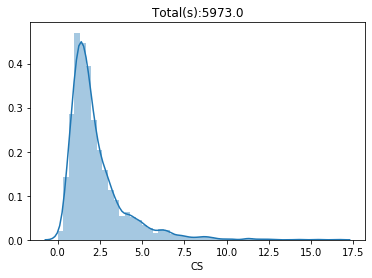

In [107]:
total_s = df.CS.sum()
plt.title("Total(s):"+str(round(total_s)))
sns.distplot(df.CS)

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(y="wav_id",x="CU",data=df.groupby("wav_id").CU.count().reset_index(),orient="h")

In [137]:
df.to_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t',index=False)

# Dataloader Scratch

In [23]:
%aimport dataloader
from IPython.display import display, Audio

In [4]:
time_to_s = lambda x: x.hour*3600+x.minute*60+x.second+x.microsecond/1e6
def parse_cut_time(x):
    xs = x.split()
    if len(xs)==1:
        return float(xs[0])
    else:
        if xs[1][0]=='B':
            try:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S.%f").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            except Exception:
                t1 = pd.to_datetime(xs[1][1:],format="%M:%S").time()
                t2 = pd.to_datetime(xs[2],format="%M:%S.%f").time()
            return time_to_s(t1) if t1<t2 else time_to_s(t2)

def prepare_allcuts_df(df,master_wav_ids):
    df = df.copy()
    df['start_time_s'] = 0.0
    df['duration_s'] = pd.to_datetime(df.CS,unit='s').dt.time.apply(time_to_s)
    df['wav_filename'] = df.audio.apply(lambda x: Path(x).stem+".wav")
    for master_wav_id in master_wav_ids:
        df.loc[
            df.wav_id==master_wav_id,'start_time_s'
        ] = df.loc[df.wav_id==master_wav_id].CU.apply(parse_cut_time)
        df.loc[
            df.wav_id==master_wav_id,'wav_filename'
        ] = df.loc[df.wav_id==master_wav_id].wav_id.apply(lambda x: str(x)+".wav")
    print("Length before dropping",len(df))
    df = df.drop_duplicates(['wav_filename','start_time_s','duration_s']).sort_values(by=['wav_filename','start_time_s'])
    print("Length after dropping",len(df))
    return df[['wav_filename','start_time_s','duration_s','location','date']].reset_index(drop=True)

In [5]:
# create TSV in final format for training data
df = pd.read_csv("../data/tsv/killer whale/allcuts.tsv",sep='\t')
master_ids = set([ int(Path(p).stem) for p in os.listdir("../data/wavmaster/") if len(Path(p).stem)==5 ])
df = prepare_allcuts_df(df,master_ids)
df.to_csv("../train_data/train.tsv",sep='\t',index=False)

Length before dropping 2647
Length after dropping 2639


# Testing out Dataloader

In [11]:
## Try out dataset class with all wav files 
df = pd.read_csv("../train_data/train.tsv",sep='\t')
df.head()

,wav_filename,start_time_s,duration_s,location,date
0,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",28-Oct-1960
1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",28-Oct-1960
2,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",28-Oct-1960
3,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",28-Oct-1960
4,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",28-Oct-1960


In [494]:
wav_dataset = dataloader.AudioFileDataset("../train_data/wav","../train_data/train.tsv",2,2)

Loading file: 60012.wav
Loading file: 60026.wav
Loading file: 61062.wav
Loading file: 64020.wav
Loading file: 64023.wav
Loading file: 64025.wav
Loading file: 64030.wav
Loading file: 64031.wav
Loading file: 66049.wav
Loading file: 79015.wav
Loading file: 89405023.wav
Loading file: 894050C0.wav
Loading file: 894050C1.wav
Loading file: 894050C2.wav
Loading file: 894050C3.wav
Loading file: 894050C4.wav
Loading file: 894050C5.wav
Loading file: 894050C6.wav
Loading file: 894050C7.wav
Loading file: 894050C8.wav
Loading file: 894050C9.wav
Loading file: 894050CA.wav
Loading file: 894050CB.wav
Loading file: 894050CC.wav
Loading file: 894050CD.wav
Loading file: 894050CE.wav
Loading file: 894050CF.wav
Loading file: 894050CG.wav
Loading file: 894050CH.wav
Loading file: 894050CI.wav
Loading file: 894050CJ.wav
Loading file: 894050CK.wav
Loading file: 894050CL.wav
Loading file: 894050CM.wav
Loading file: 894050CN.wav
Loading file: 894050CP.wav
Loading file: 894050CQ.wav
Loading file: 894050CR.wav
Load

Loading file: 92301014.wav
Loading file: 92301015.wav
Loading file: 92301016.wav
Loading file: 92301017.wav
Loading file: 92302001.wav
Loading file: 92302002.wav
Loading file: 92302003.wav
Loading file: 92302004.wav
Loading file: 92302005.wav
Loading file: 92302006.wav
Loading file: 92302007.wav
Loading file: 92302008.wav
Loading file: 92302009.wav
Loading file: 9230200A.wav
Loading file: 9230200B.wav
Loading file: 9230200C.wav
Loading file: 9230200D.wav
Loading file: 9230200E.wav
Loading file: 9230200F.wav
Loading file: 9230200G.wav
Loading file: 9230200H.wav
Loading file: 9230200I.wav
Loading file: 9230200J.wav
Loading file: 9230200K.wav
Loading file: 9230200L.wav
Loading file: 9230200M.wav
Loading file: 9230200N.wav
Loading file: 9230200O.wav
Loading file: 9230200P.wav
Loading file: 9230200Q.wav
Loading file: 9230200R.wav
Loading file: 9230200S.wav
Loading file: 9230200T.wav
Loading file: 9230200U.wav
Loading file: 9230200V.wav
Loading file: 9230200W.wav
Loading file: 9230200X.wav
L

Loading file: 9750000D.wav
Loading file: 9750000E.wav
Loading file: 9750000F.wav
Loading file: 9750000G.wav
Loading file: 9750000H.wav
Loading file: 9750000I.wav
Loading file: 9750000J.wav
Loading file: 9750000K.wav
Loading file: 9750000L.wav
Loading file: 9750000M.wav
Loading file: 9750000N.wav
Loading file: 9750000O.wav
Loading file: 9750000P.wav
Loading file: 9750000Q.wav
Loading file: 9750000R.wav
Loading file: 9750000S.wav
Loading file: 9750000T.wav
Loading file: 9750000U.wav
Loading file: 9750000V.wav
Loading file: 97501001.wav
Loading file: 97501002.wav
Loading file: 97501003.wav
Loading file: 97501004.wav
Loading file: 97501005.wav
Loading file: 97501006.wav
Loading file: 97501007.wav
Loading file: 97501008.wav
Loading file: 97501009.wav
Loading file: 9750100A.wav
Loading file: 9750100B.wav
Loading file: 9750100C.wav
Loading file: 9750100D.wav
Loading file: 9750100E.wav
Loading file: 9750100F.wav
Loading file: 9750100G.wav
Loading file: 9750100H.wav
Loading file: 9750100I.wav
L

Loading file: 9769200T.wav
Loading file: 9769200U.wav
Loading file: 9769200V.wav
Loading file: 9769200W.wav
Loading file: 9769200X.wav
Loading file: 9769200Y.wav
Loading file: 9769200Z.wav
Loading file: 97692011.wav
Loading file: 97692012.wav
Loading file: 97692013.wav
Loading file: 97692014.wav
Loading file: 97692015.wav
Loading file: 97692016.wav
Loading file: 97692017.wav
Loading file: 97692018.wav
Loading file: 97692019.wav
Loading file: 9769201A.wav
Loading file: 9769201B.wav
Loading file: 9769201C.wav
Loading file: 9769201D.wav
Loading file: 9769201E.wav
Loading file: 9769201F.wav
Loading file: 9769201G.wav
Loading file: 9769201I.wav
Loading file: 9769201J.wav
Loading file: 9769201K.wav
Loading file: 9769201L.wav
Loading file: 9769201M.wav
Loading file: 9769201N.wav
Loading file: 9769201O.wav
Loading file: 9769201P.wav
Loading file: 9769201Q.wav
Loading file: 9769201R.wav
Loading file: 9769201S.wav
Loading file: 9769201T.wav
Loading file: 9769201U.wav
Loading file: 9769201V.wav
L

Loading file: 97752008.wav
Loading file: 97752009.wav
Loading file: 9775200A.wav
Loading file: 9775200B.wav
Loading file: 9775200C.wav
Loading file: 9775200D.wav
Loading file: 9775200E.wav
Loading file: 9775200F.wav
Loading file: 9775200G.wav
Loading file: 9775200H.wav
Loading file: 9775200I.wav
Loading file: 9775200J.wav
Loading file: 9775200K.wav
Loading file: 9775200L.wav
Loading file: 9775200M.wav
Loading file: 9775200N.wav
Loading file: 9775200O.wav
Loading file: 9775200P.wav
Loading file: 9775200Q.wav
Loading file: 9775200R.wav
Loading file: 9775200S.wav
Loading file: 9775200T.wav
Loading file: 9775200U.wav
Loading file: 9775200V.wav
Loading file: 9775200W.wav
Loading file: 9775200X.wav
Loading file: 9775200Y.wav
Loading file: 9775200Z.wav
Loading file: 97752010.wav
Loading file: 97752011.wav
Loading file: 97752012.wav
Loading file: 97752013.wav
Loading file: 97752014.wav
Loading file: 97752015.wav
Loading file: 97752016.wav
Loading file: 97752017.wav
Loading file: 97753001.wav
L

Loading file: 9775901O.wav
Loading file: 9775901P.wav
Loading file: 9775901Q.wav
Loading file: 9775901R.wav
Loading file: 9775901S.wav
Loading file: 9775901T.wav
Loading file: 9775901U.wav
Loading file: 9775901V.wav
Loading file: 9775901W.wav
Loading file: 97760001.wav
Loading file: 97760002.wav
Loading file: 97760003.wav
Loading file: 97760004.wav
Loading file: 97760005.wav
Loading file: 97760006.wav
Loading file: 97760007.wav
Loading file: 97760008.wav
Loading file: 97760009.wav
Loading file: 9776000A.wav
Loading file: 9776000B.wav
Loading file: 9776000C.wav
Loading file: 9776000D.wav
Loading file: 97761001.wav
Loading file: 97761002.wav
Loading file: 97761003.wav
Loading file: 97761004.wav
Loading file: 97761005.wav
Loading file: 97761006.wav
Loading file: 97761007.wav
Loading file: 97761008.wav
Loading file: 97761009.wav
Loading file: 9776100A.wav
Loading file: 9776100B.wav
Loading file: 9776100C.wav
Loading file: 9776100D.wav
Loading file: 9776100E.wav
Loading file: 9776100F.wav
L

Loading file: 97773009.wav
Loading file: 9777300A.wav
Loading file: 9777300B.wav
Loading file: 9777300C.wav
Loading file: 9777300D.wav
Loading file: 9777300E.wav
Loading file: 9777300F.wav
Loading file: 9777300G.wav
Loading file: 9777300H.wav
Loading file: 9777300I.wav
Loading file: 9777300J.wav
Loading file: 9777300K.wav
Loading file: 9777300L.wav
Loading file: 9777300M.wav
Loading file: 9777300N.wav
Loading file: 9777300O.wav
Loading file: 9777300P.wav
Loading file: 9777300Q.wav
Loading file: 9777300R.wav
Loading file: 97774001.wav
Loading file: 97774002.wav
Loading file: 97774003.wav
Loading file: 97774004.wav
Loading file: 97774005.wav
Loading file: 97774006.wav
Loading file: 97775001.wav
Loading file: 97775002.wav
Loading file: 97775003.wav
Loading file: 97775004.wav
Loading file: 97775005.wav
Loading file: 97775006.wav
Loading file: 97775007.wav
Loading file: 97775008.wav
Loading file: 97775009.wav
Loading file: 9777500A.wav
Loading file: 9777500B.wav
Loading file: 9777500C.wav
L

Total dataset size: 7441


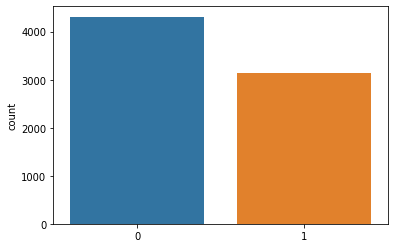

In [495]:
print("Total dataset size:",len(wav_dataset))
labels = [l[2] for l in wav_dataset.windows]
sns.countplot(labels)

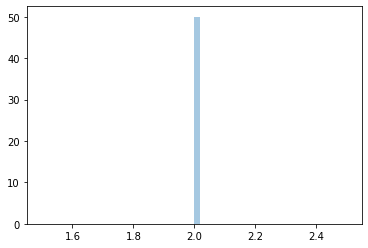

In [474]:
# get durations of windows 
durations_s = []
for w in wav_dataset.windows:
    sr = w[-1].sr
    durations_s.append((w[1]-w[0])/sr)
sns.distplot(durations_s)

In [476]:
# get sampling rate of windows 
sampling_rates = []
for w in wav_dataset.windows:
    sampling_rates.append(w[-1].sr)
set(sampling_rates)

{20000}

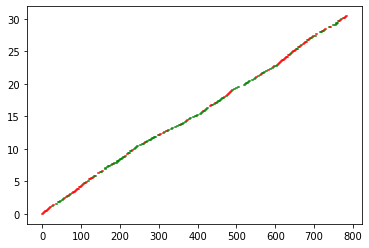

In [477]:
wav_dataset.plot_for_debug("64031.wav",'windows')

In [499]:
idx = np.random.choice(len(wav_dataset))
_, label = wav_dataset[idx]
print("Idx:",idx,"Label",label)

Idx: 2022 Label 0


In [500]:
wav_dataset.get_mode = 'audio'
sample, label = wav_dataset[idx]
Audio(sample,rate=wav_dataset.sr)

(80, 79)


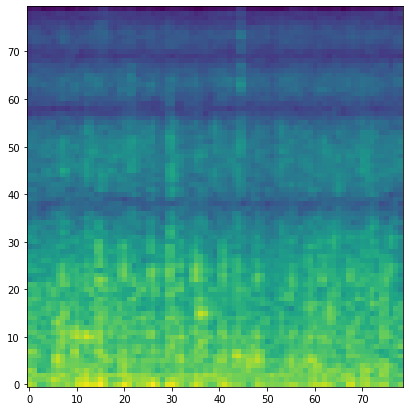

In [501]:
wav_dataset.get_mode = 'mel_spec'
mel_spec, label = wav_dataset[idx]
print(mel_spec.shape)
# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_spec,origin='lower')

(80, 79)


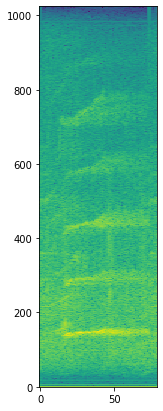

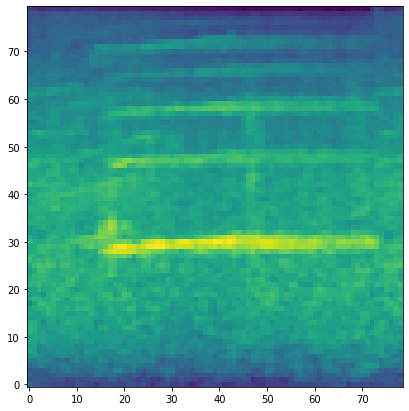

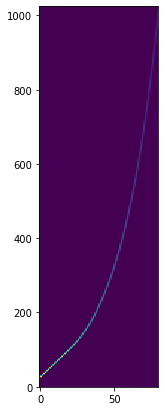

In [466]:
## Used when debugging feature extraction and setting parameters
time_sample = sample
spec = np.abs(librosa.core.stft(time_sample))
# roughly trying out some params based on https://seaworld.org/animals/all-about/killer-whale/communication/
mel_fbank = librosa.filters.mel(sr,n_fft=2048,n_mels=80,fmin=200,fmax=10000)
spec_mel = np.dot(mel_fbank,spec)
print(spec_mel.shape)

# plot the spectrogram
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(np.log(spec),origin='lower')
ax.set_aspect(0.25)

# plot the melspectrum
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(np.log(spec_mel),origin='lower')
ax.set_aspect(1)

# plot the mel fbank
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(mel_fbank.T,origin='lower')
ax.set_aspect(0.25)